In [2]:
# 必要なパッケージを呼び出す
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

In [3]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
class Model:

    def __init__(self,alpha,beta,delta,gamma,Abar,gbar,kss,css,Rss,T):

        # カリブレーション
        self.alpha = alpha 
        self.beta = beta           
        self.delta = delta 
        self.gamma = gamma
        self.Abar = Abar
        self.gbar = gbar

        # 定常状態の値
        self.kss = kss
        self.css = css    
        self.Rss = Rss
    
        # 移行過程に関する変数
        self.T = T

In [4]:
def shooting_tauc(m,c0,k0,tauc):
    """
    ------------------------------------------------------
    === ためし打ち法において、消費と資本の流列を求める関数 ===
    ------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・c0: 消費の初期値
    ・k0: 資本の初期値
    ・tauc: 消費税の流列
    <output>
    ・k: 資本の流列
    ・c: 消費の流列
    ・R: 金利
    """

    k = np.zeros(m.T+1)
    c = np.zeros(m.T+1)
    R = np.zeros(m.T+1)

    k[0] = k0
    c[0] = c0
    R[0] = 1/m.beta

    for t in range(m.T):

        k[t+1] = max(m.Abar*(k[t]**m.alpha) + (1-m.delta)*k[t] - m.gbar - c[t], 1e-4) # k>0
        R[t+1] = ((1+tauc[t])/(1+tauc[t+1])) * (1-m.delta + m.alpha*m.Abar*k[t+1]**(m.alpha-1))
        RHS = m.beta*R[t+1]*(c[t]**m.gamma)
        c[t+1] = RHS**(1/m.gamma)
    
    
    return k, c, R


In [5]:
# カリブレーション
alpha = 0.33
beta = 0.95
delta = 0.2
gamma = 2.0
Abar = 1.0
gbar = 0.2

# 定常状態の値
kss = (alpha*beta*Abar/(1-beta*(1-delta)))**(1/(1-alpha))
css = kss**alpha - delta*kss - gbar
Rss = 1 - delta + alpha*Abar*kss**(alpha-1)

# 移行過程に関する変数
T = 100

# k の初期値
k0 = kss

#### 将来の消費増税の影響 (saddlepath_shooting_tauc.m に対応)

In [6]:
m = Model(alpha,beta,delta,gamma,Abar,gbar,kss,css,Rss,T)
tauc = np.zeros(m.T+1)
tauc[10:m.T+1] = 0.2

# プロット用に先に変数を定義しておく
k = 0.0;
c = 0.0;
R = 0.0;

# bisection
cL = 0.001
cH = 5.0
diff = 1e+4

while diff > 1e-15:

    c0 = (cL+cH)/2
    k,c,R = shooting_tauc(m,c0,k0,tauc)
    err = k[m.T-1] - m.kss

    print([c0, err])

    if err > 0:
        cL = np.copy(c0)
    else:
        cH = np.copy(c0)
    
    diff = np.abs(cH-cL)

[2.5005, -1.4898564934347787]
[1.25075, -1.4898564934347787]
[0.625875, 8.017984436823532]
[0.9383125, -1.4898564934347787]
[0.78209375, -1.4898564934347787]
[0.703984375, -1.4898564934347787]
[0.6649296874999999, -1.4898564934347787]
[0.6454023437499999, 8.007320182628819]
[0.6551660156249999, -1.4898564934347787]
[0.6502841796874999, -1.4898564934347787]
[0.64784326171875, 7.996811044235486]
[0.6490637207031249, 7.958645143331783]
[0.6496739501953124, -1.4898564934347787]
[0.6493688354492186, -1.4898564934347787]
[0.6492162780761718, 7.911123283261524]
[0.6492925567626953, -1.4898564934347787]
[0.6492544174194335, 7.85497868244884]
[0.6492734870910644, 7.712844137371713]
[0.6492830219268798, -1.4898564934347787]
[0.6492782545089721, 7.432033235877592]
[0.6492806382179259, -1.4898564934347787]
[0.649279446363449, 6.473519662598403]
[0.6492800422906875, -1.4898564934347787]
[0.6492797443270683, -1.4898564934347787]
[0.6492795953452586, -1.4898564934347787]
[0.6492795208543538, 5.757432

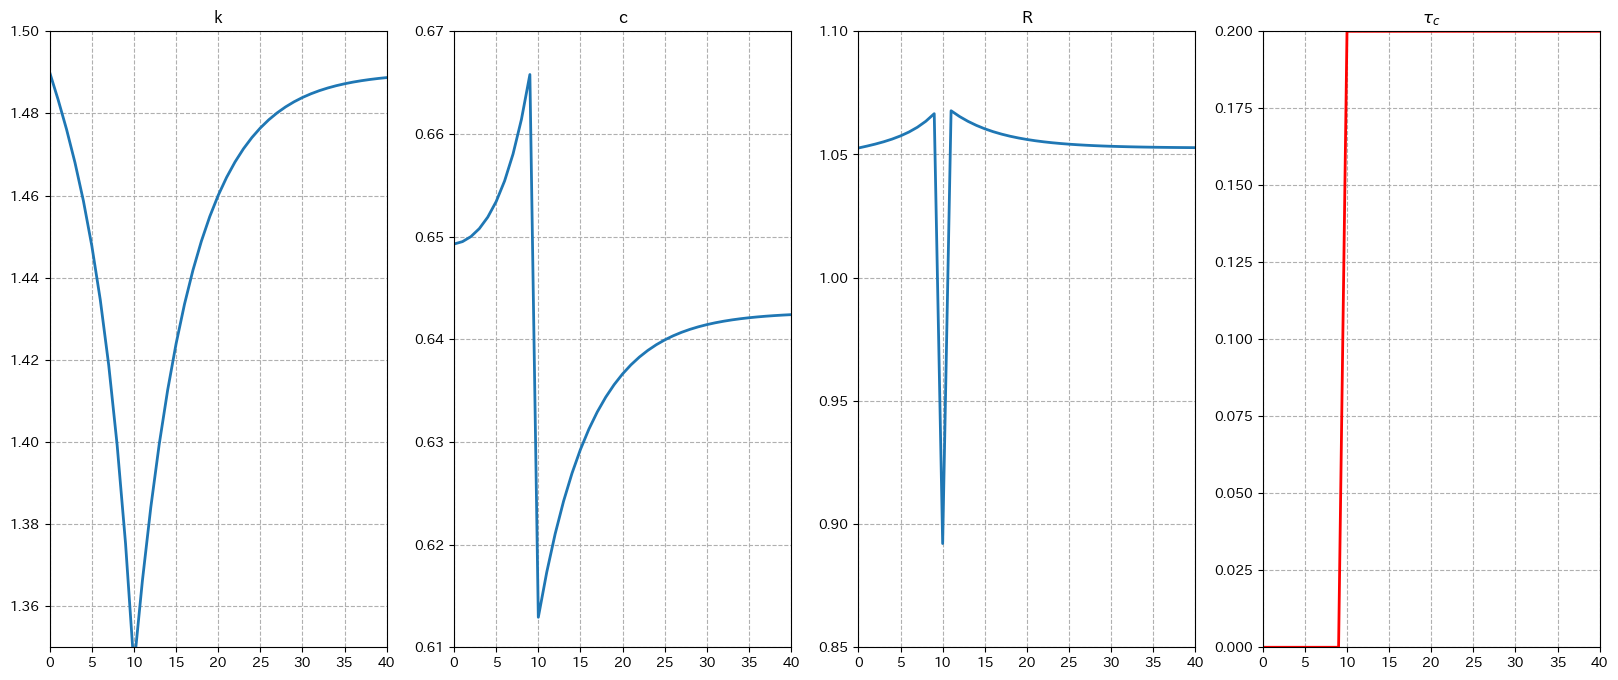

In [9]:
fig, ax = plt.subplots(1,4,figsize=(20,8))
ax[0].plot(k,lw=2)
ax[1].plot(c,lw=2)
ax[2].plot(R,lw=2)
ax[3].plot(tauc,c="r",lw=2)

ax[0].set(title="k",xlim=(0,40),ylim=(1.35,1.5))
ax[1].set(title="c",xlim=(0,40),ylim=(0.61,0.67))
ax[2].set(title="R",xlim=(0,40),ylim=(0.85,1.1))
ax[3].set(title=r"$\tau_{c}$",xlim=(0,40),ylim=(0,0.2))

for i in range(4):
    ax[i].grid(ls="--")

plt.show()